# Estimation of the Mean Function of Functional Data via Deep Neural Networks

In [92]:
# nibabel documentation: https://nipy.org/nibabel/gettingstarted.html
# https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/#:~:text=The%20number%20of%20epochs%20is%20a%20hyperparameter%20that%20defines%20the,update%20the%20internal%20model%20parameters.

In [1]:
import glob
import pandas as pd
import numpy as np
from itertools import product
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Flatten, Dense, Dropout)
import nibabel as nib
from nibabel.testing import data_path

import pydot_ng
import pydot
import pydotplus
import graphviz
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', None)

# Data definition
- There are 69 images slices contained in a 3D data cube.
- We use one slice from a given cube.
- When combining with other slices from other images we need to make sure that we select the slice from the same position inside the cube.
- Each image slice is a 95x79 matrix.
- Each row of the matrix is the output vector which needs to be predicted. These are the individual pixels in the image.
- To predict the output we need to generate the features which are the coordinates of each pixel in the output vector.
- The coordinates need to be normalized to 1 so for each coordinate needs to be divided by the $L_0$ norm of the vector.
    - Example: for the first pixel the coordinates will be $(\frac{1}{95},\frac{1}{79})$ and for the last pixel the coordinates will be $(\frac{1}{95}, \frac{79}{79})$
-------------------------------------------------------

# Model input and output
## Input: a set of coordinates e.g. $(\frac{1}{95},\frac{1}{79})$

### X:
- Get all the first coordinates as first column of the input matrix
- Get all the second coordinates as the second column of the input matrix
----------------------------------------------------------
## Output: predicted value for the pixel at that coordinate.

### Y:
- Take the matrix that contains the actual pixels for each image (this is the desired output) and ravel the array to get it into a single array of 95*79 elements each corresponding to the pixel value that needs to be predicted.
    - example: for an image with dimensions 95x79 - the total number of coordinate sets should be 95*79
    - the number of coordinates should be exactly the same as the number of pixels in the image - this will give a 1:1 correspondence between coordinates and pixels
    - even though as the image changes the pixels in the image change - the coordinates will remain the same for each pixel.

In [32]:
# %%writefile utils/preprocessing.py
import pandas as pd
import numpy as np
import nibabel as nib
from nibabel.testing import data_path

def get_mean_pixel_values(data_location='images/ADNI_data/*.nii', img_slice=20, num_images_to_use='all', plot_image_slice=True, plot_mean_image_slice=True):
    """
    Take in images files. Combine the same slices and return mean pixel values.
    """
    pixel_values_by_slice = list()
    files = glob.glob(data_location)
    
    if num_images_to_use=='all':
        n = len(files)
    else:
        n = num_images_to_use
        
    for file in glob.glob(data_location)[:n]:
        images = nib.load(file) #load the data
        data = images.get_fdata().T #transpose the original data - it should fit the format 95*79
        if plot_image_slice:
            plt.imshow((data[img_slice]), cmap='gray')
            plt.title(file)
            plt.show()
        pixel_values_by_slice.append(data[img_slice])
    
    mean_pixel_values = np.array(pixel_values_by_slice).mean(axis=0)
    if plot_mean_image_slice:
        plt.imshow(mean_pixel_values, cmap='gray')
        plt.show()
    mean_pixel_values_flattened = mean_pixel_values.ravel()
    return mean_pixel_values, mean_pixel_values_flattened

def preprocess_image(data_location='images/ADNI_data/*.nii', img_slice=20, num_images_to_use='all', plot_image_slice=True, plot_mean_image_slice=True):
    """
    Input: 
        img: Image as nii file - data cube with slices for an image
        img_slice: integer to specify which slice to select
    Return 
        X: dataframe with two columns containing X and Y coordinates.
        Y: flattened pixel values
    """
    pixel_values, pixel_values_flattened = get_mean_pixel_values(plot_image_slice=False)
    
    # Y = data[img_slice].ravel() #flatten the matrix of pixels into a single array
    Y = pd.DataFrame(pixel_values_flattened, columns=['pixel_value']) #for the first image
    
    #get the number of rows and columns for the matrix of pixels per image
    rows = pixel_values.shape[0] #number of rows
    cols = pixel_values.shape[1] #number of columns

    #generate coordinates
    row_indices = list()
    column_indices = list()

    row_coordinates =  (np.indices(dimensions=(rows, cols))[0]+1)*(1/rows) #add 1 to avoid start from 0 - multiply by 1/cols to notmalize
    column_coordinates =  (np.indices(dimensions=(rows, cols))[1]+1)*(1/cols) #add 1 to avoid start from 0 - multiply by 1/cols to notmalize

    for row in row_coordinates:
        for row_index in row:
            row_indices.append(row_index)

    for row in column_coordinates:
        for column_index in row:
            column_indices.append(column_index)
            
    X = pd.DataFrame(columns=['X_coordinate', 'Y_coordinate'])
    X['X_coordinate'] = np.array(row_indices)
    X['Y_coordinate'] = np.array(column_indices)
    
    return X, Y

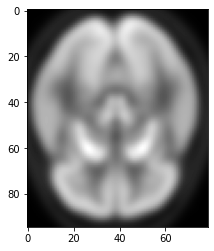

In [33]:
X, Y = preprocess_image(data_location='images/ADNI_data/*.nii', img_slice=20, num_images_to_use='all', plot_image_slice=False, plot_mean_image_slice=True)

- Should coordinates and pixels values for all images be stacked and one combined dataset be created?

## Models

In [41]:
# %%writefile models/dnn_model.py
import pandas as pd
import numpy as np
from itertools import product
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Flatten, BatchNormalization, Activation, Dense, Dropout)
import matplotlib.pyplot as plt

class Callback(tf.keras.callbacks.Callback):
    epoch_controller = 25

    def on_epoch_end(self, epoch, logs=None):
        self.epoch = epoch
        if (self.epoch%self.epoch_controller==0):
            print('Epoch: ' + str(self.epoch) + ' loss: ' + str(logs['loss']))
        
def dnn_model(X_train, 
          Y_train, 
          neurons_per_layer=1000,
          weight_initializer='standard_normal',
          activation_per_layer='relu',
          batch_normalization=True,
          epochs=500, 
          dropout_rate=0.4, 
          loss='huber', 
          l1_regularizer=False,
          batch_size=8,
          verbose=0):
    """
    create and return the desired model
    """
    #regularizer
    if l1_regularizer:
        regularizer=tf.keras.regularizers.L1(l1=1e-7)
    else:
        regularizer=None
        
    #kernel initializers to initialize weights
    if weight_initializer=='standard_normal':
        initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1)
    if weight_initializer=='he_normal':
        initializer=tf.keras.initializers.HeNormal()
        
    # add max norm constraint
    max_norm = tf.keras.constraints.MaxNorm(max_value=2, axis=0)
    
    #batch normalization
    if batch_normalization:
        normalize_batch=BatchNormalization()
    else:
        normalize_batch=tf.keras.layers.Layer(trainable=False)
        
    
    model = keras.models.Sequential([
        Flatten(input_shape=X.shape[1:]),
        normalize_batch,
        Dense(neurons_per_layer, kernel_initializer=initializer, kernel_regularizer=regularizer, kernel_constraint=max_norm),
        normalize_batch,
        Activation(activation_per_layer),
        Dropout(dropout_rate),
        Dense(neurons_per_layer, kernel_initializer=initializer, kernel_regularizer=regularizer, kernel_constraint=max_norm),
        normalize_batch,
        Activation(activation_per_layer),
        Dropout(dropout_rate),
        Dense(neurons_per_layer, kernel_initializer=initializer, kernel_regularizer=regularizer, kernel_constraint=max_norm),
        normalize_batch,
        Activation(activation_per_layer),
        Dropout(dropout_rate),
        Dense(1)
    ])
            
    #define loss to minimize
    if loss=='huber':
        loss_to_minimize = tf.keras.losses.Huber() 
    elif loss=='mse':
        loss_to_minimize = tf.keras.losses.MeanSquaredError()
    
    #optimizer
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.001, decay=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07, 
        amsgrad=False, name='Adam'
    )
    
    #compile the model
    model.compile(loss=loss_to_minimize, 
                  optimizer=optimizer)
    
    #model fit
    model_history = model.fit(X_train, Y_train, 
                              batch_size=batch_size, 
                              epochs=epochs,  
                              callbacks=[Callback()], 
                              verbose=verbose)
    
    return model_history, model


def train_predict(X, Y, **model_params):
    """
    Train and predict pixel values from the model
    """
    neurons_per_layer = model_params["neurons_per_layer"] if "neurons_per_layer" in model_params else 100
    weight_initializer = model_params["weight_initializer"] if "weight_initializer" in model_params else "standard_normal"
    activation_per_layer = model_params["activation_per_layer"] if "activation_per_layer" in model_params else "relu"
    batch_normalization = model_params["batch_normalization"] if "batch_normalization" in model_params else True
    epochs = model_params["epochs"] if "epochs" in model_params else 100
    dropout_rate = model_params["dropout_rate"] if "dropout_rate" in model_params else 0.25
    loss = model_params["loss"] if "loss" in model_params else "mse"
    l1_regularizer = model_params["l1_regularizer"] if "l1_regularizer" in model_params else True
    batch_size = model_params["batch_size"] if "batch_size" in model_params else 8
    verbose = model_params["verbose"] if "verbose" in model_params else 0
    
    model_history, model = dnn_model(X, Y,
                                     neurons_per_layer=neurons_per_layer,
                                     weight_initializer=weight_initializer,
                                     activation_per_layer=activation_per_layer, 
                                     batch_normalization=batch_normalization,
                                     epochs=epochs, 
                                     dropout_rate=dropout_rate, 
                                     loss=loss, 
                                     l1_regularizer=l1_regularizer, 
                                     verbose=verbose)
    y_pred = model.predict(X)
    
    # plt.imshow(np.reshape(y_pred, (95, 79)), cmap='gray') #display the recovered image
    
    return model, model_history, y_pred

Original Mean Image


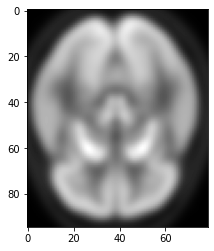

Epochs: 300, Dropout Rate: 0, Batch Size: 2
******************************
Epoch: 0 loss: 17.95490074157715
Epoch: 25 loss: 0.03118285723030567
Epoch: 50 loss: 0.0075602419674396515
Epoch: 75 loss: 0.004027996677905321
Epoch: 100 loss: 0.0023583972360938787
Epoch: 125 loss: 0.0017810914432629943
Epoch: 150 loss: 0.001550855115056038
Epoch: 175 loss: 0.001259481767192483
Epoch: 200 loss: 0.0011339025804772973
Epoch: 225 loss: 0.001030700746923685
Epoch: 250 loss: 0.000916740158572793
Epoch: 275 loss: 0.0008593371603637934


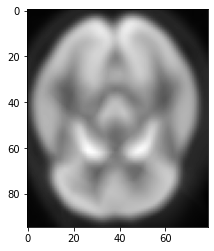

Epochs: 300, Dropout Rate: 0, Batch Size: 4
******************************
Epoch: 0 loss: 30.39038848876953
Epoch: 25 loss: 0.023613987490534782
Epoch: 50 loss: 0.006605989299714565
Epoch: 75 loss: 0.002421907614916563
Epoch: 100 loss: 0.0017130726482719183
Epoch: 125 loss: 0.0013849094975739717
Epoch: 150 loss: 0.0009528107475489378
Epoch: 175 loss: 0.0009322116966359317
Epoch: 200 loss: 0.0006550784455612302
Epoch: 225 loss: 0.0007565745036117733
Epoch: 250 loss: 0.0005911769694648683
Epoch: 275 loss: 0.000524747883901


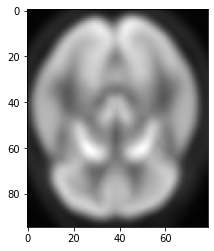

Epochs: 300, Dropout Rate: 0, Batch Size: 6
******************************
Epoch: 0 loss: 99.73331451416016
Epoch: 25 loss: 0.03378487750887871
Epoch: 50 loss: 0.00736965611577034
Epoch: 75 loss: 0.004242009483277798
Epoch: 100 loss: 0.0022394887637346983
Epoch: 125 loss: 0.001639623544178903
Epoch: 150 loss: 0.0015616645105183125
Epoch: 175 loss: 0.0011482266709208488
Epoch: 200 loss: 0.000940190686378628
Epoch: 225 loss: 0.0008019869565032423
Epoch: 250 loss: 0.00071895238943398
Epoch: 275 loss: 0.0006938977749086916


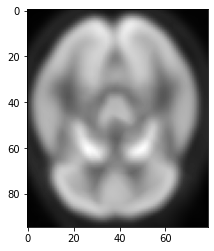

Epochs: 300, Dropout Rate: 0, Batch Size: 8
******************************
Epoch: 0 loss: 875.0205688476562
Epoch: 25 loss: 0.04700843617320061
Epoch: 50 loss: 0.007683892734348774
Epoch: 75 loss: 0.003744957037270069
Epoch: 100 loss: 0.002958089578896761
Epoch: 125 loss: 0.0015671206638216972
Epoch: 150 loss: 0.0012618390610441566
Epoch: 175 loss: 0.0012004049494862556
Epoch: 200 loss: 0.0010642361594364047
Epoch: 225 loss: 0.0009229916613548994
Epoch: 250 loss: 0.000743393728043884
Epoch: 275 loss: 0.0006284405244514346


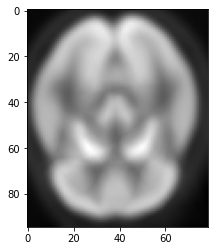

Epochs: 500, Dropout Rate: 0, Batch Size: 2
******************************
Epoch: 0 loss: 214.49301147460938
Epoch: 25 loss: 0.03746727481484413
Epoch: 50 loss: 0.006657019257545471
Epoch: 75 loss: 0.002517400775104761
Epoch: 100 loss: 0.002001117216423154
Epoch: 125 loss: 0.0012522351462394
Epoch: 150 loss: 0.0010424158535897732
Epoch: 175 loss: 0.0009143315255641937
Epoch: 200 loss: 0.0007693966617807746
Epoch: 225 loss: 0.0006788340397179127
Epoch: 250 loss: 0.0005892264889553189
Epoch: 275 loss: 0.0006028742645867169
Epoch: 300 loss: 0.0005651187966577709
Epoch: 325 loss: 0.0004990700399503112
Epoch: 350 loss: 0.00046244883560575545
Epoch: 375 loss: 0.0004431368433870375
Epoch: 400 loss: 0.00045053972280584276
Epoch: 425 loss: 0.0004222180286888033
Epoch: 450 loss: 0.0004030309210065752
Epoch: 475 loss: 0.00039433359052054584


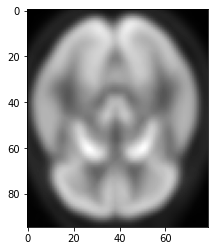

Epochs: 500, Dropout Rate: 0, Batch Size: 4
******************************
Epoch: 0 loss: 236.61924743652344
Epoch: 25 loss: 0.03996322676539421
Epoch: 50 loss: 0.007549504283815622
Epoch: 75 loss: 0.003658441361039877
Epoch: 100 loss: 0.002027378883212805
Epoch: 125 loss: 0.0014759032055735588
Epoch: 150 loss: 0.0011535219382494688
Epoch: 175 loss: 0.0011168494820594788
Epoch: 200 loss: 0.0008500853436999023
Epoch: 225 loss: 0.0008671021787449718
Epoch: 250 loss: 0.0006497850990854204
Epoch: 275 loss: 0.0007141270907595754
Epoch: 300 loss: 0.0005895079229958355
Epoch: 325 loss: 0.0005884998245164752
Epoch: 350 loss: 0.0005221887258812785
Epoch: 375 loss: 0.0005019202944822609
Epoch: 400 loss: 0.0004801252798642963
Epoch: 425 loss: 0.0004664465377572924
Epoch: 450 loss: 0.00045381003292277455
Epoch: 475 loss: 0.0004360387974884361


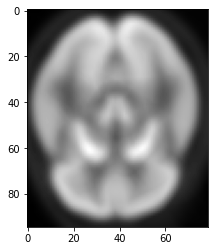

Epochs: 500, Dropout Rate: 0, Batch Size: 6
******************************
Epoch: 0 loss: 209.79522705078125
Epoch: 25 loss: 0.03721465915441513
Epoch: 50 loss: 0.008099458180367947
Epoch: 75 loss: 0.004479452036321163
Epoch: 100 loss: 0.0028576774057000875
Epoch: 125 loss: 0.0015050822403281927
Epoch: 150 loss: 0.001179129583761096
Epoch: 175 loss: 0.001108770607970655
Epoch: 200 loss: 0.0008521717973053455
Epoch: 225 loss: 0.0006844557356089354
Epoch: 250 loss: 0.0006479969015344977
Epoch: 275 loss: 0.0005625428166240454
Epoch: 300 loss: 0.0005346015677787364
Epoch: 325 loss: 0.0005001688259653747
Epoch: 350 loss: 0.0004724001628346741
Epoch: 375 loss: 0.00044706303742714226
Epoch: 400 loss: 0.00047494834871031344
Epoch: 425 loss: 0.00041274711838923395
Epoch: 450 loss: 0.00040727827581577003
Epoch: 475 loss: 0.0004134848131798208


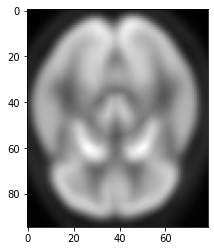

Epochs: 500, Dropout Rate: 0, Batch Size: 8
******************************
Epoch: 0 loss: 105.77123260498047
Epoch: 25 loss: 0.03295619413256645
Epoch: 50 loss: 0.0073808724991977215
Epoch: 75 loss: 0.004712528083473444
Epoch: 100 loss: 0.002473232103511691
Epoch: 125 loss: 0.0019475482404232025
Epoch: 150 loss: 0.001352442428469658
Epoch: 175 loss: 0.0009651362197473645
Epoch: 200 loss: 0.0009694239706732333
Epoch: 225 loss: 0.0009105661883950233
Epoch: 250 loss: 0.0007284778403118253
Epoch: 275 loss: 0.0006746267899870872
Epoch: 300 loss: 0.0006346933078020811
Epoch: 325 loss: 0.0005581578006967902
Epoch: 350 loss: 0.0005762689397670329
Epoch: 375 loss: 0.0005450681783258915
Epoch: 400 loss: 0.0005146046751178801
Epoch: 425 loss: 0.00046733234194107354
Epoch: 450 loss: 0.00045299422345124185
Epoch: 475 loss: 0.00045315452734939754


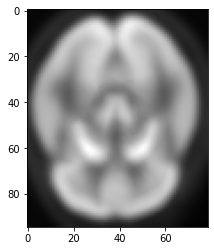

In [46]:
# preds = list()
print('Original Mean Image')
X, Y = preprocess_image(data_location='images/ADNI_data/*.nii', img_slice=20, num_images_to_use='all', plot_image_slice=False, plot_mean_image_slice=True)
for num_epochs in [300, 500]:
    for batch_size in [2, 4, 6, 8]:
        model_params = {"neurons_per_layer": 1000,
                       "weight_initializer":"standard_normal",
                       "activation_per_layer": "relu",
                       "batch_normalization":False,
                       "epochs": num_epochs,
                       "dropout_rate": 0,
                       "loss": "mse",
                       "l1_regularizer": True,
                       "batch_size": batch_size,
                       "verbose": 0}
        
        print(f'Epochs: {model_params["epochs"]}, Dropout Rate: {model_params["dropout_rate"]}, Batch Size: {batch_size}')
        print('*'*30)
        model, model_history, y_pred = train_predict(X, Y, **model_params)
        plt.imshow(np.reshape(y_pred, (95, 79)), cmap='gray') #display the recovered image
        plt.show()
        # preds.append(y_pred)

# for pred in preds:
#     print('*'*30)
#     print(f'Epochs: {model_params["epochs"]}, Dropout Rate: {model_params["dropout_rate"]}, Batch Size: {batch_size}')
#     plt.imshow(np.reshape(pred, (95, 79)), cmap='gray') #display the recovered image
#     plt.show()
#     print('*'*30)

Epochs: 300, Dropout Rate: 0.4
******************************
Epoch: 0 loss: 228.10086059570312
Epoch: 25 loss: 0.13714762032032013
Epoch: 50 loss: 0.10898341238498688
Epoch: 75 loss: 0.10456278175115585
Epoch: 100 loss: 0.09298165142536163
Epoch: 125 loss: 0.08846680074930191
Epoch: 150 loss: 0.0846078023314476
Epoch: 175 loss: 0.07907545566558838
Epoch: 200 loss: 0.07381608337163925
Epoch: 225 loss: 0.07098884135484695
Epoch: 250 loss: 0.06737595796585083
Epoch: 275 loss: 0.06505277752876282
******************************
Epochs: 300, Dropout Rate: 0.5
******************************
Epoch: 0 loss: 313.6800231933594
Epoch: 25 loss: 0.20950092375278473
Epoch: 50 loss: 0.12819527089595795
Epoch: 75 loss: 0.12096978724002838
Epoch: 100 loss: 0.1129564717411995
Epoch: 125 loss: 0.11212629824876785
Epoch: 150 loss: 0.11120618134737015
Epoch: 175 loss: 0.10735122114419937
Epoch: 200 loss: 0.10638415068387985
Epoch: 225 loss: 0.10556157678365707
Epoch: 250 loss: 0.1042882427573204
Epoch: 275

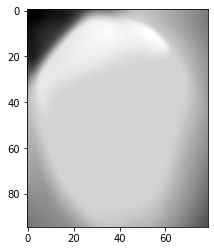

In [42]:
for num_epochs in [300, 500]:
    for rate in [0.40, 0.50]:
        model_params = {"neurons_per_layer": 1000,
                       "weight_initializer":"standard_normal",
                       "activation_per_layer": "relu",
                       "batch_normalization":False,
                       "epochs": num_epochs,
                       "dropout_rate": rate,
                       "loss": "huber",
                       "l1_regularizer": False,
                       "verbose": 0}

        X, Y = preprocess_image("images/data.nii", img_slice=20)
        print(f'Epochs: {model_params["epochs"]}, Dropout Rate: {model_params["dropout_rate"]}')
        print('*'*30)
        model, model_history, y_pred = train_predict(X, Y, **model_params)
        plt.imshow(np.reshape(y_pred, (95, 79)), cmap='gray') #display the recovered image
        print('*'*30)

In [54]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 2)                 0         
                                                                 
 dense_12 (Dense)            (None, 1000)              3000      
                                                                 
 dense_13 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_14 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_3 (Dropout)         (None, 1000)              0         
                                                                 
 dense_15 (Dense)            (None, 1)                 1001      
                                                                 
Total params: 2,006,001
Trainable params: 2,006,001
No

In [12]:
# keras.utils.plot_model(dnn_model)